# 성장률 계산 & 이상치 완화 데모 노트북

이 노트북은 `data/export_value.csv`(또는 `data/extract_values.csv`)를 읽어
MoM·YoY·QoQ를 계산하고, 작은 분모/극단치로 인한 폭주를 필터링한 통계를 비교합니다.

기본 가정
- 2020년은 YoY에서 전년 데이터가 없어 제외
- 분모 0 이슈는 'flag' 방식으로 처리
- 작은 분모 하위 1% 컷 + 1–99% 윈저라이즈


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


In [2]:
import numpy as np
import pandas as pd

def growth(curr, prev, mode='flag', eps=1e-6):
    if mode == 'epsilon':
        prev = prev.fillna(0) + eps
        return (curr - prev) / prev
    g = (curr - prev.replace(0, np.nan)) / prev.replace(0, np.nan)
    if mode == 'flag':
        g = g.mask(prev == 0, np.nan)
    return g

def add_prev_cols(df):
    df = df.sort_values(['symbol','date']).reset_index(drop=True)
    df['prev_month'] = df.groupby('symbol')['export_value'].shift(1)
    df['prev_year']  = df.groupby('symbol')['export_value'].shift(12)
    return df

def quarterly_mean(df_monthly):
    q = df_monthly[['symbol','date','export_value']].copy()
    q['year'] = q['date'].dt.year
    q['quarter'] = q['date'].dt.quarter
    q = (q.groupby(['symbol','year','quarter'], as_index=False)['export_value']
           .mean().rename(columns={'export_value':'q_avg'}))
    q = q.sort_values(['symbol','year','quarter']).reset_index(drop=True)
    q['prev_q'] = q.groupby('symbol')['q_avg'].shift(1)
    return q

def metric_stats(s):
    s = pd.Series(s)
    return pd.Series({
        'mean': s.mean(),
        'std': s.std(),
        'min': s.min(),
        'max': s.max(),
        'null_count': s.isna().sum(),
        'count': s.count()
    })

def mask_small_denoms(df, pm_q=1, py_q=1):
    pm = df['prev_month']
    py = df['prev_year']
    pm_cut = np.nanpercentile(pm.dropna(), pm_q) if pm.notna().any() else np.nan
    py_cut = np.nanpercentile(py.dropna(), py_q) if py.notna().any() else np.nan
    mom = df['MoM'].where(df['prev_month']>=pm_cut) if not np.isnan(pm_cut) else df['MoM']
    yoy = df['YoY'].where(df['prev_year']>=py_cut)   if not np.isnan(py_cut) else df['YoY']
    return mom, yoy

def winsorize(s, low=1, high=99):
    s = pd.Series(s).dropna()
    if s.empty:
        return s
    lo, hi = np.percentile(s, [low, high])
    return s.clip(lo, hi)

def robust_stats(s):
    s = pd.Series(s).dropna()
    if s.empty:
        return pd.Series({'mean':np.nan,'std':np.nan,'median':np.nan,'iqr':np.nan,'p1':np.nan,'p99':np.nan,'min':np.nan,'max':np.nan,'count':0})
    med = s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    p1, p99 = np.percentile(s, [1,99])
    return pd.Series({'mean':s.mean(),'std':s.std(),'median':med,'iqr':iqr,'p1':p1,'p99':p99,'min':s.min(),'max':s.max(),'count':s.count()})


In [11]:
!cd

C:\Users\PC2502


In [14]:
csv_path = r'C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project\data\export_value.csv'
if not os.path.exists(csv_path):
    csv_path = r'C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project\data\export_value.csv'

df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['symbol','date']).reset_index(drop=True)
df = add_prev_cols(df)

df['MoM'] = growth(df['export_value'], df['prev_month'], mode='flag')
df['YoY'] = growth(df['export_value'], df['prev_year'],  mode='flag')
df.loc[df['date'].dt.year == 2020, 'YoY'] = np.nan

q = quarterly_mean(df)
q['QoQ'] = growth(q['q_avg'], q['prev_q'], mode='flag')

m0 = metric_stats(df['MoM']).to_frame().T.assign(metric='MoM')
y0 = metric_stats(df['YoY']).to_frame().T.assign(metric='YoY')
q0 = metric_stats(q['QoQ']).to_frame().T.assign(metric='QoQ')
raw_stats = pd.concat([m0,y0,q0], ignore_index=True)[['metric','mean','std','min','max','null_count','count']]
raw_stats


,metric,mean,std,min,max,null_count,count
0,MoM,73.563324,7559.181286,-0.999963,991521.250000,349.0,22310.0
1,YoY,83.802790,6711.611484,-1.000000,768983.929487,4157.0,18502.0
2,QoQ,75.621043,6432.467173,-0.999977,557976.441176,349.0,7525.0


In [15]:
mom_masked, yoy_masked = mask_small_denoms(df, pm_q=1, py_q=1)
qoq_masked = q['QoQ'].where(q['prev_q'] >= np.nanpercentile(q['prev_q'].dropna(), 1)) if q['prev_q'].notna().any() else q['QoQ']

mom_w = winsorize(mom_masked, 1, 99)
yoy_w = winsorize(yoy_masked, 1, 99)
qoq_w = winsorize(qoq_masked, 1, 99)

stats_filtered = pd.DataFrame({
    'MoM_filtered': robust_stats(mom_w),
    'YoY_filtered': robust_stats(yoy_w),
    'QoQ_filtered': robust_stats(qoq_w)
})
stats_filtered


,MoM_filtered,YoY_filtered,QoQ_filtered
mean,0.193371,0.481566,0.121516
std,0.957439,1.768888,0.645012
median,0.006053,0.075191,0.016608
iqr,0.452624,0.745004,0.369486
p1,-0.898912,-0.934899,-0.819345
p99,6.487667,12.877778,4.220090
min,-0.898971,-0.934929,-0.819597
max,6.490916,12.910075,4.273754
count,22086.000000,18316.000000,7449.000000


C:\Users\PC2502\AppData\Local\Temp\ipykernel_5048\2085747460.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mom_w.dropna(), yoy_w.dropna()], labels=['MoM','YoY'], showfliers=False)


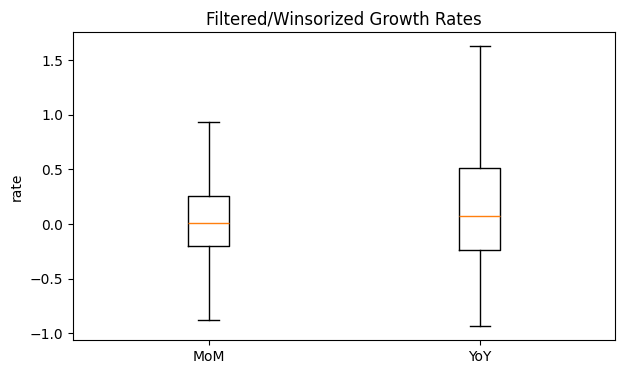

In [16]:
plt.figure(figsize=(7,4))
plt.boxplot([mom_w.dropna(), yoy_w.dropna()], labels=['MoM','YoY'], showfliers=False)
plt.title('Filtered/Winsorized Growth Rates')
plt.ylabel('rate')
plt.show()


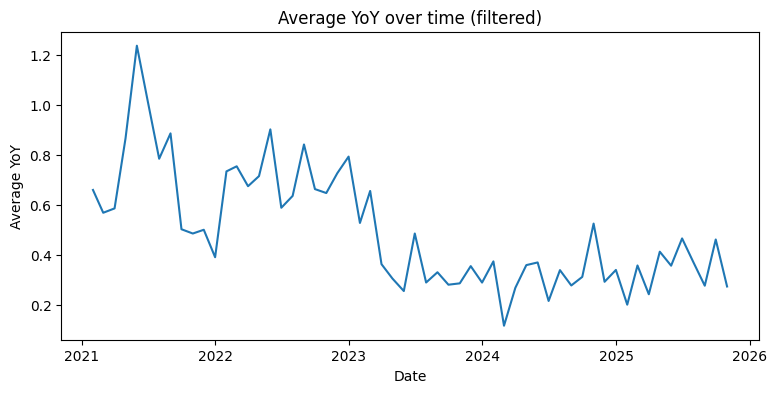

In [17]:
avg_yoy = yoy_w.groupby(df.loc[yoy_w.index, 'date']).mean()
plt.figure(figsize=(9,4))
plt.plot(avg_yoy.index, avg_yoy.values)
plt.title('Average YoY over time (filtered)')
plt.xlabel('Date')
plt.ylabel('Average YoY')
plt.show()
